In [1]:
import os

# Limit GPU memory preallocation (so JAX doesn't reserve all memory at startup)
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = ".9"  # use 50% of GPU memory
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false" # disable full preallocation

import jax
print(jax.default_backend())
jax.config.update("jax_enable_x64", True)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


cpu


In [2]:
import argparse
import yaml
from tqdm import tqdm
import sys
import copy
from functools import partial


import pickle

import jax
import jax.numpy as jnp

import optax   

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

# @RADHA, new stuff:
from utils.fit_utils import randomize_params, freeze_lower_orders, create_mask



from helpers.data import get_pdf_toy_JAX, read_in_data_JAX



# Params and Initialization

### @RADHA, IMPORTANT CHANGE

I made it so mstar is the lowest power of alpha that can appear in either g_star or g_mn.

If mstar = 1, then the 0th row of both matrices correspond to alpha^1 terms.

If mstar = 0, then the 0th row of both matrices correspond to alpha^0 terms. 

Look at `utils.distribution_utils.build_q_mstar`to see how this works. 

In [ ]:
# TODO: Replace this with Radha's YAML files
mstar = 1
m = 2
n = 7
dist = "thrust"

mult_factor = 2 if dist == "thrust" else 1

m0 = 1 # Number of additional nuisance parameter orders (1 for matching)


random_init = False 
lr = 0.002 # [CHANGED DEFAULT]
weight_decay = 0.001 # [CHANGED DEFAULT]
tau_annealing = 0 # Start with larger errors and slowly anneal down to the real errors. 0 = real errors only
tau_integer = 2 # 1/fraction for number of epochs. 2 = half epochs, 10 = one tenth epochs, etc

epochs = 500000 # [CHANGED DEFAULT]
verbose_epochs = 5000 # [NEW] After how many epochs to interrupt and plot. Longer = more CPU intensive but also faster
bogo_epochs = 1000 # [NEW] Number of epochs for each bogo iteration

bogo_population = 32 # [NEW] Number of parallel bogos
bogo_scale = 0.1 # [NEW] Scale of randomization for bogo init
batch_size = 320*1
seed = 42

zero_error_scale = 1.0 
freeze_previous_order = True 
bogo_init = True
random_batch = False

name = f"{dist}_m{m}_n{n}"
init_from = f"{dist}_m{m-1}_n{n}"

# Seed stuff
np.random.seed(seed)
jax_key = jax.random.PRNGKey(seed)
jax_key, key1, key2, key3, key4, key5, key6, key7 = jax.random.split(jax_key, 8)

# Colors
colors = ["red", "violet", "blue"][::-1]
darkcolors = ["darkred", "darkviolet", "darkblue"][::-1]


# Initialize params
params = {
    "g_star" : -np.zeros((m+1 - mstar, n+1)),
    "g_coeffs" : -np.zeros((m+1 - mstar, n+1)),
    "thetas" : np.zeros((m+1 - mstar,)) ,
    "thetas_coeffs" : np.zeros((m+1 - mstar,)) ,
    "temps" : 1 * np.ones((m+1 - mstar,)),
    "temps_coeffs" : 1 * np.ones((m+1 - mstar,)),
    "temps_positive" : 1 * np.ones((m+1 - mstar,)),
}

# temp_limits = [0.0, np.inf]


factorials = np.ones_like(params["g_star"])
for mi in range(params["g_star"].shape[0]):
    for ni in range(params["g_star"].shape[1]):
        factorials[mi, ni] = 1 / math.factorial(mi + mstar) / math.factorial(ni)


# # For flavor, slightly smarter inits
signs = (-1) * np.power(-1, np.arange(n + 1) % 2)

params["g_star"][0,1] = -1
params["g_coeffs"][0,1] = 0
params["thetas"][0] = 0.5
if m == 2:
    params["thetas_coeffs"][0] = 0
    params["thetas"][1] = -0
    # params["g_star"][1,2] = 0


# Decent sign initialization
for mi in range(m+1-mstar):
    params["g_star"][mi] *= signs #* factorials[mi]
    params["g_coeffs"][mi] *= signs #* factorials[mi]


if random_init:

    # Initialize params
    params = {
        "g_star" : np.array(-jnp.abs(jax.random.normal(key1, shape = params["g_star"].shape) * 0.1)),
        "g_coeffs" : np.array(-jnp.abs(jax.random.normal(key2, shape = params["g_star"].shape) * 0.1)),
        "thetas" : np.array(0.5 * jax.random.uniform(key3, shape = (m+1 - mstar,))) ,
        "thetas_coeffs" : np.array(0.5 * jax.random.uniform(key4, shape = (m+1 - mstar,))) ,
        "temps" : np.array(jax.random.uniform(key5, shape = (m+1 - mstar,))),
        "temps_coeffs" : np.array(jax.random.uniform(key6, shape = (m+1 - mstar,))),
        "temps_positive" : np.array(jax.random.uniform(key7, shape = (m+1 - mstar,))),
    }


In [4]:
# Init from previous file:

if init_from:

    try:
        with open(f"output_JAX/{init_from}_params.pkl", "rb") as f:
            init_params = pickle.load(f)

        g_coeffs_init = init_params["g_coeffs"]
        g_star_init = init_params["g_star"]
        thetas_init = init_params["thetas"]
        thetas_coeffs_init = init_params["thetas_coeffs"]
        temps_init = init_params["temps"]
        temps_coeffs_init = init_params["temps_coeffs"]
        temps_pos_init = init_params["temps_positive"]


        init_m, init_n = g_coeffs_init.shape

        params["g_coeffs"][:init_m, :init_n] = g_coeffs_init
        params["g_star"][:init_m, :init_n] = g_star_init
        params["thetas"][:init_m] = thetas_init
        params["thetas_coeffs"][:init_m] = thetas_coeffs_init
        params["temps"][:init_m] = temps_init 
        params["temps_coeffs"][:init_m] = temps_coeffs_init
        params["temps_positive"][:init_m] = temps_pos_init
    
    except:
        print(f"No file" + f"output_JAX/{init_from}_params.pkl")
        


print(params)

for k in params.keys():
    params[k] = jnp.array(params[k])

# Save the original params for the purpose of freezing
original_params = params.copy()



No fileoutput_JAX/thrust_m0_n7_params.pkl
{'g_star': array([[ 0., -1.,  0., -0.,  0., -0.,  0., -0.]]), 'g_coeffs': array([[ 0.,  0.,  0., -0.,  0., -0.,  0., -0.]]), 'thetas': array([0.5]), 'thetas_coeffs': array([0.]), 'temps': array([1.]), 'temps_coeffs': array([1.]), 'temps_positive': array([1.])}


# Compilation 

Notation:
Functions with the postfix `vmap` are vmapped in `t` but NOT `alpha`. So you can run it for a batch of `ts` but with a SCALAR `alpha`

Functions with the postfix `vmap2` are vmapped in `t` and `alpha` seperately. So you can run it for a batch of N `ts` and a batch of `M` alphas, and the result will be an (M, N) array.

In [5]:
from utils.function_utils import polynomial, taylor_expand_in_alpha
from utils.distribution_utils import build_q_mstar
from rikabplotlib.plot_utils import newplot

q = build_q_mstar(mstar)

# compile
q_vmap = jax.vmap(q, in_axes=(0,None,None,None,None,None,None,None,None))


# Taylor Expansions
q0_vmap = jax.vmap(taylor_expand_in_alpha(q, 0), in_axes=(0,None,None,None,None,None,None,None,None))
q1_vmap = jax.vmap(taylor_expand_in_alpha(q, 1), in_axes=(0,None,None,None,None,None,None,None,None))
q2_vmap = jax.vmap(taylor_expand_in_alpha(q, 2), in_axes=(0,None,None,None,None,None,None,None,None))
q3_vmap = jax.vmap(taylor_expand_in_alpha(q, 3), in_axes=(0,None,None,None,None,None,None,None,None))
# ... Add more if necessary, can loop if we really have to

qm_vmap = [q0_vmap, q1_vmap, q2_vmap, q3_vmap]

# ##### Second vmap over alpha #####
q_vmap2 = jax.vmap(q_vmap, in_axes = (None, 0, None, None, None, None, None, None, None))
qm_vmap2 = []
for qi in qm_vmap:
    qi_vmap2 = jax.vmap(qi, in_axes = (None, 0, None, None, None, None, None, None, None))
    qm_vmap2.append(qi_vmap2)



# Select the Taylor Expansion Function
CHOSEN_Q_VMAP = qm_vmap[m]
CHOSEN_Q_VMAP2 = qm_vmap2[m]


# Helper functions
@jax.jit
def Q_ANSATZ(ts, alphas, params):

    # Negative last g star and coeffs
    g_coeffs = params["g_coeffs"].at[:,-1].set(-jax.nn.softplus(params["g_coeffs"][:,-1]))
    g_star = params["g_star"].at[:,-1].set(-jax.nn.softplus(params["g_star"][:,-1]))



    # Positive temps
    temps = params["temps"].at[:].set( jax.nn.softplus( params["temps"][:]))
    temps_coeffs = params["temps_coeffs"].at[:].set( jax.nn.softplus(params["temps_coeffs"][:]))
    temps_pos = params["temps_positive"].at[:].set(jax.nn.softplus( params["temps_positive"][:]))
    temps_coeffs = temps_coeffs.at[-mstar:].set(1e-1)

    return q_vmap2(ts, alphas, g_star, g_coeffs, params["thetas"], params["thetas_coeffs"], temps, temps_coeffs, temps_pos)

@jax.jit
def QM_ANSATZ(ts, alphas, params):

    # Negative last g star and coeffs
    g_coeffs = params["g_coeffs"].at[:,-1].set(-jax.nn.softplus(params["g_coeffs"][:,-1]))
    g_star = params["g_star"].at[:,-1].set(-jax.nn.softplus(params["g_star"][:,-1]))    

    # Positive temps
    temps = params["temps"].at[:].set( jax.nn.softplus( params["temps"][:]))
    temps_coeffs = params["temps_coeffs"].at[:].set( jax.nn.softplus(params["temps_coeffs"][:]))
    temps_pos = params["temps_positive"].at[:].set(jax.nn.softplus( params["temps_positive"][:]))
    temps_coeffs = temps_coeffs.at[-mstar:].set(1e-1)

    return CHOSEN_Q_VMAP2(ts, alphas, g_star, g_coeffs, params["thetas"], params["thetas_coeffs"], temps, temps_coeffs, temps_pos)



# Data Setup

KeyboardInterrupt: 

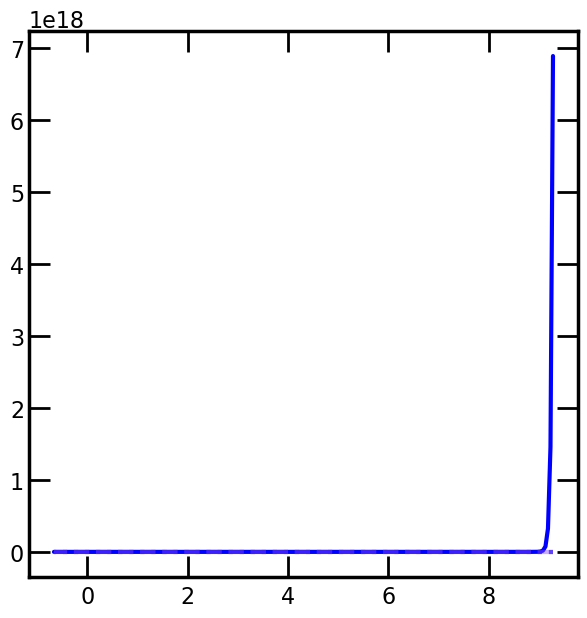

In [6]:
if dist in ["thrust", "c_param"]:
    data_true_dict = None
    data_dict, t_bins, t_bin_centers = read_in_data_JAX(dist, m)
else:
    data_dict = {}
    data_true_dict = {}
    alphas = np.arange(.005, .325, 0.001)
    t_bins = jnp.linspace(0, 10, 201)
    t_bin_centers = (t_bins[1:] + t_bins[:-1])/2

    for a in alphas:
        y_data = get_pdf_toy_JAX(a, dist, t_bin_centers, m)
        y_true_data = get_pdf_toy_JAX(a, dist, t_bin_centers, -1)
        data_dict[a] = np.reshape(y_data, (-1, 1)), np.reshape(0.001 * jnp.ones_like(y_data), (-1, 1))
        data_true_dict[a] = np.reshape(y_true_data, (-1, 1)), np.reshape(0.001 * jnp.ones_like(y_true_data), (-1, 1))


x_bin_centers = jnp.exp(-t_bin_centers)

alpha_keys = np.array(list(data_dict.keys()))
alpha_keys_float = list(data_dict.keys())

t_min = jnp.min(t_bins)
t_max = jnp.max(t_bins)

ALPHA_MAX = 0.4
# alpha_keys_float = alpha_keys_float[alpha_keys <= ALPHA_MAX]
alpha_keys = alpha_keys[alpha_keys <= ALPHA_MAX]

# Keys of interest
keys = np.array([0.05, 0.1, 0.2,])

# Find the keys in the list closest to these values (to deal with floating point errors)
for (k, key) in enumerate(keys):

    closest_key = alpha_keys_float[np.argmin(np.abs(key - alpha_keys))]
    keys[k] = closest_key


# Make an array of ys and yerrs so we dont have to keep the dictionary around
ys = []
yerrs = []
for key in alpha_keys:
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]

    # clamp yerr by its nonzero minimum

    min_y_err = zero_error_scale * np.min(yerr[yerr > 0])
    yerr = np.clip(yerr, a_min=min_y_err.item(), a_max=None)
    
    ys.append(y)
    yerrs.append(yerr)

ys = jnp.array(ys)
yerrs = jnp.array(yerrs)

ys_xs = ys / x_bin_centers
yerrs_xs = yerrs / x_bin_centers

def make_plot(params):

    # Make a plot of the data 
    fig, ax = newplot("full", use_tex = False)
    q_vals = Q_ANSATZ(t_bin_centers, keys, params)
    q_taylor_vals = QM_ANSATZ(t_bin_centers, keys, params)

    for (k, key) in enumerate(keys):
        y, yerr = data_dict[key]
        y = y[:,0]
        yerr = yerr[:,0]


        min_y_err = zero_error_scale * np.min(yerr[yerr > 0])
        yerr = np.clip(yerr, a_min=min_y_err.item(), a_max=None)

        plt.errorbar(t_bin_centers, y, yerr, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
        plt.plot(t_bin_centers, q_vals[k], color = colors[k])
        plt.plot(t_bin_centers, q_taylor_vals[k], color = colors[k], alpha = 0.75, ls = "dotted")

        if data_true_dict:
            y_true, _ = data_true_dict[key]
            plt.plot(t_bin_centers, y_true,  color = darkcolors[k], ls = "-",label = r"True $\alpha_s = $" + f"{key}")


        # plt.plot(t_bin_centers, q_taylor_vals[k] / q_vals[k], color = colors[k], alpha = 0.75, ls = "-.")

    plt.ylim(-0.1, 2)
    # plt.xscale("log")
    plt.xlabel(r"$t$")
    plt.ylabel(r"$p(t | \alpha)$")
    plt.legend(loc = "upper left")


make_plot(params)


# Loss and Training

In [ ]:
# Set up the loss as a function of the parameters

loss_epsilon = 0

# Weighted MSE
@jax.jit
def loss_function(params, alphas, ys, yerrs, original_params):

    # # Freeze lower orders
    # params = freeze_lower_orders(params, original_params, m0, mstar)


    y_preds = (QM_ANSATZ(t_bin_centers, alphas, params))
    mean_errors = jnp.mean(yerrs)
    y_errs_rescaled = yerrs / mean_errors

    # Sum over axis 0, mean over axis 1
    loss = jnp.sum((y_preds - ys)**2 /(y_errs_rescaled**2 + loss_epsilon), axis=0)
    loss = jnp.mean(loss)

    return loss / 2


print("Initial Loss: ", loss_function(params, alpha_keys, ys, yerrs, original_params))

loss, grad_loss = jax.value_and_grad(loss_function)(params, alpha_keys, ys, yerrs, original_params)
print(loss)
print(grad_loss)


Initial Loss:  7001213654.147184
7001213654.147184
{'g_coeffs': Array([[-1.97859025e+07, -1.76787753e+08, -7.92781527e+08,
        -2.37641444e+09, -5.35338799e+09, -9.66341505e+09,
        -1.45560903e+10,  9.40798033e+09],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]], dtype=float64), 'g_star': Array([[ 6.88081574e+07,  5.01953529e+07, -4.48098978e+08,
        -2.03667447e+09, -5.20512302e+09, -9.87175488e+09,
        -1.51913621e+10,  9.91396245e+09],
       [-2.56519926e+04, -1.83092336e+05, -7.17259065e+05,
        -1.98785169e+06, -4.27449793e+06, -7.49253365e+06,
        -1.10612374e+07,  7.04320237e+06]], dtype=float64), 'temps': Array([1.28927328e+03, 1.37028628e-16], dtype=float64), 'temps_coeffs': Array([3.13253766e-83, 0.00000000e+00], dtype=float64), 'temps_positive': Array([5.08753158e+04, 1.45868322e+00], dtype=float64), 'thetas': Array([6.29147723e+05, 1.33

In [ ]:
q_taylor_vals = QM_ANSATZ(t_bin_centers, keys, params)
print("Initial Taylor Values: ", q_taylor_vals)

Initial Taylor Values:  [[ 1.68516609e+03  1.56326312e+03  1.44961521e+03  1.34369863e+03
   1.24502561e+03  1.15313631e+03  1.06759674e+03  9.88000565e+02
   9.13960760e+02  8.45117685e+02  7.81132916e+02  7.21686893e+02
   6.66481168e+02  6.15232394e+02  5.67677774e+02  5.23569527e+02
   4.82674676e+02  4.44776630e+02  4.09669451e+02  3.77162115e+02
   3.47075424e+02  3.19241821e+02  2.93504330e+02  2.69714963e+02
   2.47736691e+02  2.27441274e+02  2.08708550e+02  1.91426152e+02
   1.75489433e+02  1.60800885e+02  1.47268995e+02  1.34809046e+02
   1.23341556e+02  1.12792847e+02  1.03094307e+02  9.41816907e+01
   8.59957284e+01  7.84809037e+01  7.15858695e+01  6.52628376e+01
   5.94674038e+01  5.41583911e+01  4.92975675e+01  4.48495387e+01
   4.07814788e+01  3.70629449e+01  3.36658367e+01  3.05640676e+01
   2.77335609e+01  2.51520738e+01  2.27989994e+01  2.06553973e+01
   1.87036940e+01  1.69277609e+01  1.53127156e+01  1.38448039e+01
   1.25114296e+01  1.13009400e+01  1.02026696e+01  9

### Projector

Function to make sure that the polynomial's final coefficients always have the correct sign, and if freezing is on, keep the original parameters

In [ ]:
@jax.jit
def project(params, epoch):

    # Get the signs right
    g_star = params["g_star"]
    g_coeffs = params["g_coeffs"]
    thetas = params["thetas"]
    thetas_coeffs = params["thetas_coeffs"]
    temps = params["temps"]
    temps_coeffs = params["temps_coeffs"]
    temps_pos = params["temps_positive"]


    # g_star = g_star.at[m, -1].set(-jnp.abs(g_star[m, -1]))
    # g_coeffs = g_coeffs.at[m, -1].set(-jnp.abs(g_coeffs[m, -1]))

    # # Clip temp
    # temps = jnp.clip(temps, temp_limits[0], temp_limits[1])
    # temps_coeffs = jnp.clip(temps_coeffs, temp_limits[0], temp_limits[1])
    # temps_pos = jnp.clip(temps_pos, temp_limits[0], temp_limits[1])

    # temps = temp_limits[0] + jnp.ones_like(temps) * epoch * (temp_limits[1] - temp_limits[0])
    # temps_coeffs = temp_limits[0] + jnp.ones_like(temps_coeffs) * epoch * (temp_limits[1] - temp_limits[0])

    g_coeffs = g_coeffs.at[m-mstar:,:].set(0)  # Current order doesn't count
    thetas_coeffs = thetas_coeffs.at[m-mstar:,].set(-1)  # Current order doesn't count
    temps_coeffs = temps_coeffs.at[m-mstar:,].set(1e-1)  # Current order doesn't count

    # Restore the original parameters if frozen
    if freeze_previous_order and m > 1:

        g_coeffs_init = original_params["g_coeffs"]
        g_star_init = original_params["g_star"]
        thetas_init = original_params["thetas"]
        thetas_coeffs_init = original_params["thetas_coeffs"]
        temps_init = original_params["temps"]
        temps_coeffs_init = original_params["temps_coeffs"]
        temps_pos_init = original_params["temps_positive"]

        g_star = g_star.at[:-1].set(g_star_init[:-1])
        g_coeffs = g_coeffs.at[:-1-mstar].set(g_coeffs_init[:-1-mstar])
        thetas = thetas.at[:-1].set(thetas_init[:-1])
        thetas_coeffs = thetas_coeffs.at[:-1-mstar].set(thetas_coeffs_init[:-1-mstar])
        temps = temps.at[:-1].set(temps_init[:-1])
        temps_coeffs = temps_coeffs.at[:-1-mstar].set(temps_coeffs_init[:-1-mstar])
        temps_pos = temps_pos.at[:-1].set(temps_pos_init[:-1])



    params["g_star"] = g_star
    params["g_coeffs"] = g_coeffs
    params["thetas"] = thetas
    params["thetas_coeffs"] = thetas_coeffs
    params["temps"] = temps
    params["temps_coeffs"] = temps_coeffs
    params["temps_positive"] = temps_pos


    return params

### BOGO Initializer

In [ ]:
# Helper to concatenate pytrees along time axis
def _concat_pytrees_time(a, b):
    if a is None:
        return jax.tree_map(lambda x: np.array(x), b)
    return jax.tree_map(lambda x, y: np.concatenate([x, np.array(y)], axis=0), a, b)


# Helper to guard against NaNs
def _nan_guard_tree(tree):
    return jax.tree_map(lambda g: jnp.where(jnp.isfinite(g), g, 0.0), tree)


def _get_train_step(lr, wd):

    opt = optax.adamw(lr, weight_decay=wd)

    @partial(jax.jit, donate_argnums=(1,2,3))
    def train_step(epoch, params, opt_state, random_key, alpha, original_params, total_epochs):
        key, subkey = jax.random.split(random_key)

        # Loosen errors
        median_error = jnp.median(yerrs)
        # tau = jnp.exp(-10 * epoch / total_epochs) * median_error
        # tau = jnp.where(epoch < total_epochs//2, median_error * 0.5 * (1 - epoch/(total_epochs//2)), 0.0)
        tau = tau_annealing * median_error * (1.0 - epoch / total_epochs) * 0.5

        # turn tau into 0 halfway through
        tau = jnp.where(epoch < total_epochs // tau_integer, tau, 0.0)

        effective_error = jnp.sqrt(yerrs**2 + tau**2)


        loss, grad_loss = jax.value_and_grad(loss_function)(params, alpha_keys, ys, effective_error, original_params)
        grad_loss = _nan_guard_tree(grad_loss)

        updates, opt_state = opt.update(grad_loss, opt_state, params=params)

        mask = create_mask(params, m0, mstar)
        updates = jax.tree_map(lambda u, m: jnp.where(m, u, 0), updates, mask)

        params = optax.apply_updates(params, updates)
        # params = project(params, original_params)
        return params, opt_state, loss, subkey

    return train_step, opt


def _get_run_chunk(lr: float, wd: float):
    train_step, opt = _get_train_step(lr, wd)

    @partial(jax.jit, static_argnames=("n_steps",), donate_argnums=(2))
    def run_chunk(params, opt_state, key, alpha, original_params, start, n_steps):

        def body(carry, i):

            params_, opt_state_, key_ = carry
            epoch = start + i
            params_, opt_state_, loss_, key_ = train_step(epoch, params_, opt_state_, key_, alpha, original_params, n_steps)
            return (params_, opt_state_, key_), (loss_, params_)
        

        (params, opt_state, key), (losses_chunk, params_chunk) = jax.lax.scan(
            body, (params, opt_state, key), jnp.arange(n_steps)
        )

        

        return params, opt_state, key, losses_chunk, params_chunk

    return run_chunk, opt



@partial(jax.jit, static_argnames=("bogo_epochs","population"))
def bogo_init_batched(params, best_params, best_loss, alpha, bogo_epochs, bogo_scale, population, jax_key, original_params):


    init = (params, best_params, best_loss, jnp.array(0, dtype=jnp.int32), jax_key)


    def body(carry, i):
        params, best_params, best_loss, counter, key = carry
        key, subkey = jax.random.split(key)

        # counter-gated scale
        scale = bogo_scale / ( (jnp.sqrt(counter.astype(jnp.float32)))**2 + 1.0 ) * (bogo_epochs-i)/bogo_epochs

        # make K keys, randomize K candidates, project
        keys = jax.random.split(subkey, population)

        def make_one(k):
            p = randomize_params(best_params, scale=scale, key=k, m0 = m0, mstar = mstar)
            return project(p, original_params)

        Ps = jax.vmap(make_one)(keys)

        # losses for all K in parallel
        median_error = jnp.median(yerrs)
        tau = tau_annealing * median_error * (1.0 - i / bogo_epochs) * 0.5  

        # turn tau into 0 halfway through
        tau = jnp.where(i < bogo_epochs // tau_integer, tau, 0.0)

        effective_error = jnp.sqrt(yerrs**2 + tau**2)
        losses = jax.vmap(lambda p: loss_function(p, alpha_keys, ys, effective_error, original_params))(Ps)

        # best of this batch
        argmin = jnp.argmin(losses)
        Pbest = jax.tree_map(lambda x: x[argmin], Ps)

        # Get the (non-tau) loss of the best in this batch
        Lbest = loss_function(Pbest, alpha_keys, ys, yerrs, original_params)

        # compare batch-best to global best
        better = Lbest < best_loss
        best_params = jax.tree_map(lambda new, old: jnp.where(better, new, old), Pbest, best_params)
        best_loss  = jnp.where(better, Lbest, best_loss)

        

        # increment counter ONLY when improved
        counter = counter + jnp.where(better, jnp.int32(1), jnp.int32(0))

        return (params, best_params, best_loss, counter, key), (best_loss, best_params)

    (params, best_params, best_loss, counter, jax_key), (loss_track, params_track) = jax.lax.scan(
        body, init, jnp.arange(bogo_epochs)
    )
    return params, best_params, best_loss, jax_key, loss_track, params_track





def train(alpha, init_params, epochs, lr, jax_key,
          verbose=True, verbose_epochs=1000,
          bogo_init=True, early_stopping=1000,
          bogo_scale=1, bogo_epochs=5000,population=256):

    params = copy.deepcopy(init_params)
    original_params = copy.deepcopy(init_params)
    best_params = copy.deepcopy(init_params)
    best_loss = float(loss_function(init_params, alpha_keys, ys, yerrs, original_params))
    print(f"Original Loss : {best_loss}")

    # bogo init 
    if bogo_init:
        best_loss = loss_function(params, alpha_keys, ys, yerrs, original_params)
        params, best_params, best_loss, jax_key, bogo_losses, params_log = bogo_init_batched(
            params, params, best_loss, alpha, bogo_epochs, bogo_scale,population, jax_key, original_params
        )
        params = best_params

        # pick the epoch with the minimum loss 
        min_arg = int(jnp.argmin(bogo_losses))
        params = best_params
        print(f"After bogo : {float(bogo_losses[min_arg])}")

        if verbose:

            make_plot(params)
            
            #Flatten the pytree across time into arrays per key s
            bp_host = jax.device_get(params_log)  # pytree of stacked arrays
            best_params_log = []  
            T = bogo_losses.shape[0]
            for t in range(T):
                snap = {
                    "g_star":          bp_host["g_star"][t],
                    "g_coeffs":        bp_host["g_coeffs"][t],
                    "thetas":          bp_host["thetas"][t],
                    "temps":           bp_host["temps"][t],
                    "thetas_coeffs":   bp_host["thetas_coeffs"][t],
                    "temps_coeffs":    bp_host["temps_coeffs"][t],
                    "temps_positive":  bp_host["temps_positive"][t],
                }
                best_params_log.append(snap)

            fig, ax = newplot("full", width=8*5, subplot_array=(1, 5), use_tex=False)

            losses_arr   = np.array(jax.device_get(bogo_losses))
            g_star_log   = np.array([b["g_star"] for b in best_params_log])
            g_coeffs_log = np.array([b["g_coeffs"] for b in best_params_log])
            thetas_log   = np.array([b["thetas"] for b in best_params_log])
            temps_log    = np.array([b["temps"] for b in best_params_log])
            thetas_c_log = np.array([b["thetas_coeffs"] for b in best_params_log])
            temps_c_log  = np.array([b["temps_coeffs"] for b in best_params_log])
            temps_p_log  = np.array([b["temps_positive"] for b in best_params_log])

            color = iter(cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[1] * g_coeffs_log.shape[2])))

            ax[0].plot(losses_arr)
            ax[0].set_yscale("log")

            for mi in range(g_star_log.shape[1]):
                for ni in range(g_star_log.shape[2]):
                    c = next(color)
                    ax[1].plot(g_star_log[:, mi, ni], color=c, label=f"g_star_{mi}{ni}")
                    ax[2].plot(g_coeffs_log[:, mi, ni], color=c, label=f"g_coeffs_{mi}{ni}")
                ax[3].plot(thetas_log[:, mi], label=f"theta_{mi}", color=c)
                ax[4].plot(temps_log[:, mi], label=f"temp_{mi}", color=c)
                ax[3].plot(thetas_c_log[:, mi], label=f"theta_coeffs_{mi}", ls="--", color=c)
                ax[4].plot(temps_c_log[:, mi], label=f"temp_coeffs_{mi}", ls="--", color=c)
                ax[4].plot(temps_p_log[:, mi], label=f"temp_positive_{mi}", ls=":", color=c)

            ax[0].set_ylabel("loss");   ax[0].set_xlabel("epochs")
            ax[1].legend(); ax[1].set_ylabel("g_star");   ax[1].set_xlabel("epochs")
            ax[2].legend(); ax[2].set_ylabel("g_coeffs"); ax[2].set_xlabel("epochs")
            ax[3].legend(); ax[3].set_ylabel("theta");    ax[3].set_xlabel("epochs")
            ax[4].legend(); ax[4].set_ylabel("temp");     ax[4].set_xlabel("epochs")


        

    

            plt.show()

    run_chunk, opt = _get_run_chunk(float(lr), float(weight_decay))
    opt_state = opt.init(params)

    # logs 
    losses = []
    params_log = []
    params_steps_hist = None

    if verbose:
        p0 = jax.tree_map(lambda x: np.array(x), jax.device_get(params))
        g_coeffs_log = [p0["g_coeffs"]]
        g_star_log   = [p0["g_star"]]
        thetas_log   = [p0["thetas"]]
        temps_log    = [p0["temps"]]
        thetas_c_log = [p0["thetas_coeffs"]]
        temps_c_log  = [p0["temps_coeffs"]]
        temps_p_log  = [p0["temps_positive"]]


    # run in chunks, plot every verbose_epochs
    total_epochs = int(epochs)
    epoch_start = 0

    while epoch_start < total_epochs:
        chunk = min(verbose_epochs, total_epochs - epoch_start)
        # single compiled scan over the chunk
        params, opt_state, jax_key, losses_chunk, params_chunk = run_chunk(
            params, opt_state, jax_key, alpha, original_params, epoch_start, chunk
        )   


        # bring back the chunk losses once
        losses_chunk = np.array(jax.device_get(losses_chunk))
        losses.extend(losses_chunk.tolist())

        # params_steps_hist = _concat_pytrees_time(params_steps_hist, params_chunk)
        params_log.append(jax.device_get(params_chunk))

        # plotting
        if verbose:
            
            print(f"Epoch {epoch_start + chunk} / {total_epochs}, Loss: {losses_chunk[-1]:.6f}")

            make_plot(params)

            fig, ax = newplot("full", width=8*5, subplot_array=(1, 5), use_tex=False)
            losses_ = np.array(losses)

            # append param logs for the panel
            # for t in range(chunk):
            p_np = jax.tree_map(lambda x: np.array(x), jax.device_get(params))
            g_coeffs_log.append(p_np['g_coeffs'])
            g_star_log.append(p_np['g_star'])
            thetas_log.append(p_np['thetas'])
            temps_log.append(p_np["temps"])
            thetas_c_log.append(p_np["thetas_coeffs"])
            temps_c_log.append(p_np["temps_coeffs"])
            temps_p_log.append(p_np["temps_positive"])
            # p_np = jax.tree_map(lambda x: np.array(x), jax.device_get(params))
            # g_coeffs_log.append(p_np['g_coeffs'])
            # g_star_log.append(p_np['g_star'])
            # thetas_log.append(p_np['thetas'])
            # temps_log.append(p_np["temps"])
            # thetas_c_log.append(p_np["thetas_coeffs"])
            # temps_c_log.append(p_np["temps_coeffs"])
            # temps_p_log.append(p_np["temps_positive"])

            g_star_log_   = np.stack(g_star_log,   axis=0)
            g_coeffs_log_ = np.stack(g_coeffs_log, axis=0)
            thetas_log_   = np.stack(thetas_log,   axis=0)
            temps_log_    = np.stack(temps_log,    axis=0)
            thetas_c_log_ = np.stack(thetas_c_log, axis=0)
            temps_c_log_  = np.stack(temps_c_log,  axis=0)
            temps_p_log_  = np.stack(temps_p_log,  axis=0)

            color = iter(cm.hsv(np.linspace(0, 1, g_coeffs_log_.shape[1] * g_coeffs_log_.shape[2])))

            ax[0].plot(losses_)
            ax[0].set_yscale("log")

            for mi in range(g_star_log_.shape[1]):
                for ni in range(g_star_log_.shape[2]):
                    c = next(color)
                    ax[1].plot(g_star_log_[:, mi, ni], color=c, label=f"g_star_{mi}{ni}")
                    ax[2].plot(g_coeffs_log_[:, mi, ni], color=c, label=f"g_coeffs_{mi}{ni}")

                ax[3].plot(thetas_log_[:, mi], label=f"theta_{mi}", color=c)
                ax[4].plot(temps_log_[:, mi], label=f"beta_{mi}", color=c)
                ax[3].plot(thetas_c_log_[:, mi], label=f"theta_coeffs_{mi}", color=c, ls="--")
                ax[4].plot(temps_c_log_[:, mi], label=f"beta_coeffs_{mi}", color=c, ls="--")
                ax[4].plot(temps_p_log_[:, mi], label=f"beta_positive_{mi}", ls=":", color=c)

            ax[0].set_ylabel("loss"); ax[0].set_xlabel("epochs")
            ax[1].legend(); ax[1].set_ylabel("g_star"); ax[1].set_xlabel("epochs")
            ax[2].legend(); ax[2].set_ylabel("g_coeffs"); ax[2].set_xlabel("epochs")
            ax[3].legend(); ax[3].set_ylabel("theta"); ax[3].set_xlabel("epochs")
            ax[4].legend(); ax[4].set_ylabel("beta"); ax[4].set_xlabel("epochs")


            # If epoch > epochs // tau_integer, draw a vertical line
            if epoch_start + chunk > epochs // tau_integer and tau_annealing > 0:
                ax[0].axvline(x=epochs // tau_integer, color='k', ls='--')
                ax[1].axvline(x=epochs // tau_integer, color='k', ls='--')
                ax[2].axvline(x=epochs // tau_integer, color='k', ls='--')
                ax[3].axvline(x=epochs // tau_integer, color='k', ls='--')
                ax[4].axvline(x=epochs // tau_integer, color='k', ls='--')




            plt.yscale("log")
            plt.show()

        # tqdm text (same look)


        # early stopping 
        best_loss_now = float(np.min(losses))
        arg_best_loss = int(np.argmin(losses))
        global_epoch = epoch_start + chunk - 1
        if global_epoch - arg_best_loss > early_stopping:
            print(f"EARLY STOPPING!!!! at {global_epoch}")
            
            break

        epoch_start += chunk

    # same return values
    best_epoch = int(np.argmin(losses))
    
    
    all_params_log = {key:[]for key in params_log[0].keys()}
    
    for key in params_log[0].keys():
        for chunk in range(len(params_log)):
            all_params_log[key].append(params_log[chunk][key])
    
    for key in params_log[0].keys():
        all_params_log[key] = np.concatenate(all_params_log[key])
        print(key, all_params_log[key].shape)
    
    best_params_out = {key: all_params_log[key][best_epoch] for key in all_params_log.keys()}
    
    params_log = all_params_log
    

    # Get the (non-tau) best loss of everything in the log after epochs // tau_integer
    start_epoch = epochs // tau_integer
    if tau_annealing == 0:
        start_epoch = 0

    nontau_losses = losses[start_epoch:]
    nontau_best_epoch = int(np.argmin(nontau_losses)) + start_epoch
    print(f"Best non-tau loss at epoch {nontau_best_epoch} with loss {nontau_losses[nontau_best_epoch - start_epoch]}")
    
    best_params_out = {key: all_params_log[key][nontau_best_epoch] for key in all_params_log.keys()}
    

    return losses[nontau_best_epoch], best_params_out, np.array(losses), params_log

Original Loss : 7001213654.147184


2025-11-08 13:08:00.353540: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %sort.2 = f64[64000]{0} sort(f64[64000]{0} %constant.8769), dimensions={0}, is_stable=true, to_apply=%region_40.3270, metadata={op_name="jit(bogo_init_batched)/jit(main)/while/body/jit(median)/jit(quantile)/sort[dimension=0 is_stable=True num_keys=1]" source_file="/tmp/ipykernel_418586/863649245.py" source_line=98}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-11-08 13:08:09.177308: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 9.823863538s
Constant folding an instruction 

After bogo : 41913290.3680666


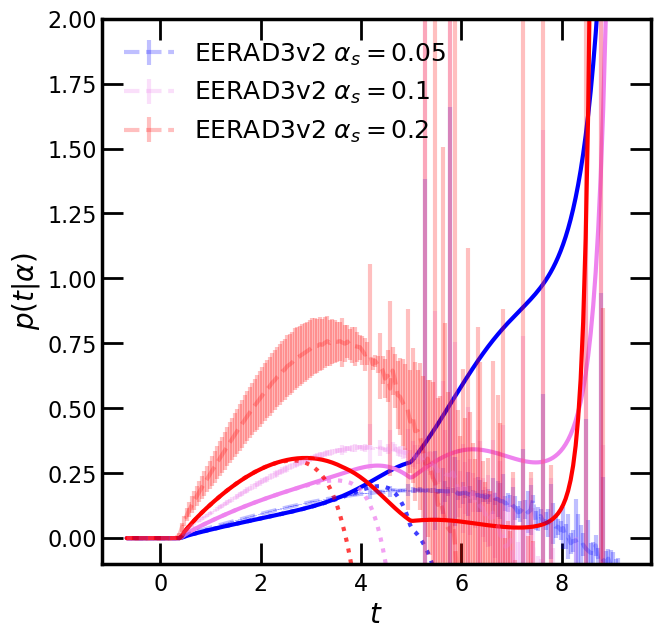

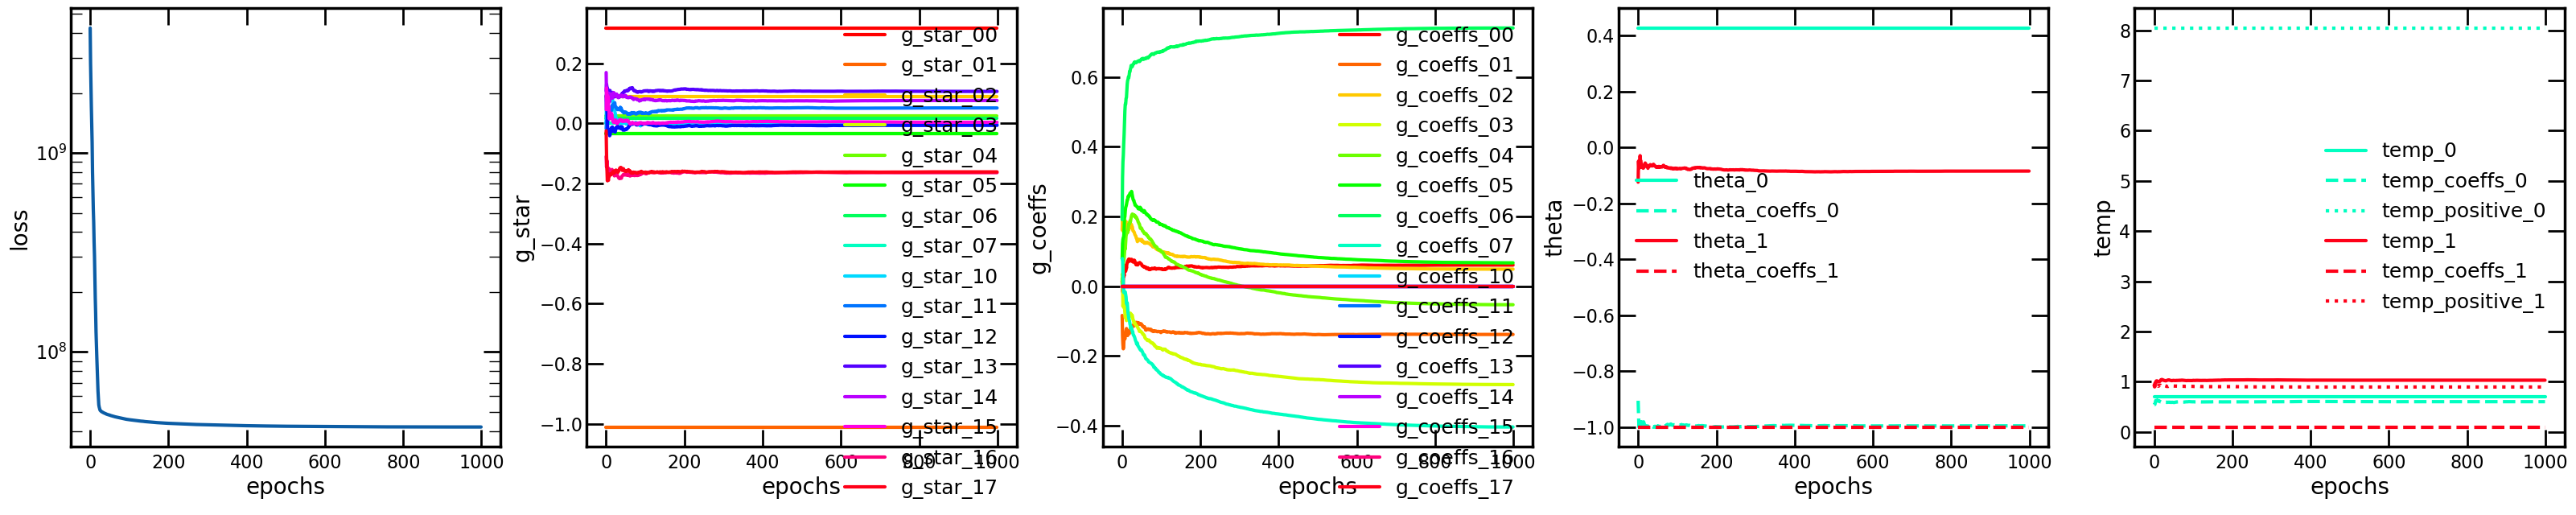

2025-11-08 13:09:07.838251: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 2s:

  %sort.3 = f64[64000]{0} sort(f64[64000]{0} %constant.6313), dimensions={0}, is_stable=true, to_apply=%region_4.126, metadata={op_name="jit(run_chunk)/jit(main)/while/body/jit(train_step)/jit(median)/jit(quantile)/sort[dimension=0 is_stable=True num_keys=1]" source_file="/tmp/ipykernel_418586/863649245.py" source_line=98}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-11-08 13:09:14.505622: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 8.667561868s
Constant folding an instru

Epoch 5000 / 500000, Loss: 39525133.958327


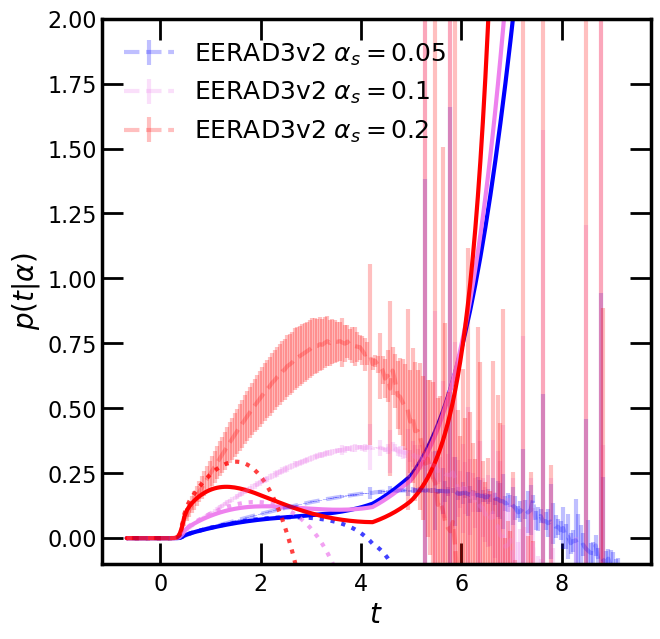

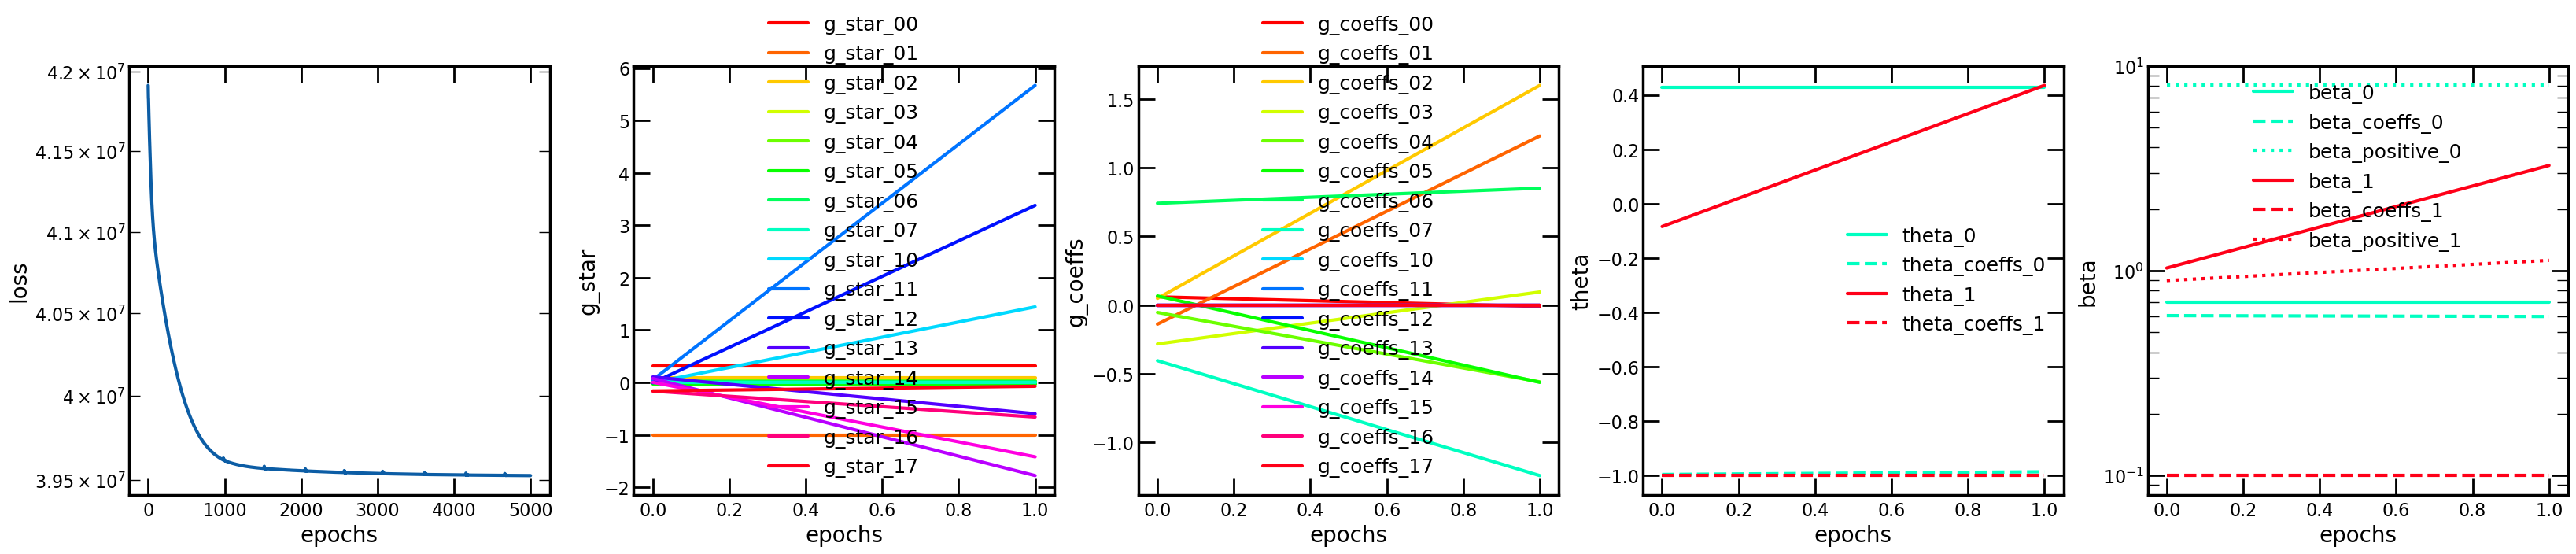

Epoch 10000 / 500000, Loss: 39518970.505307


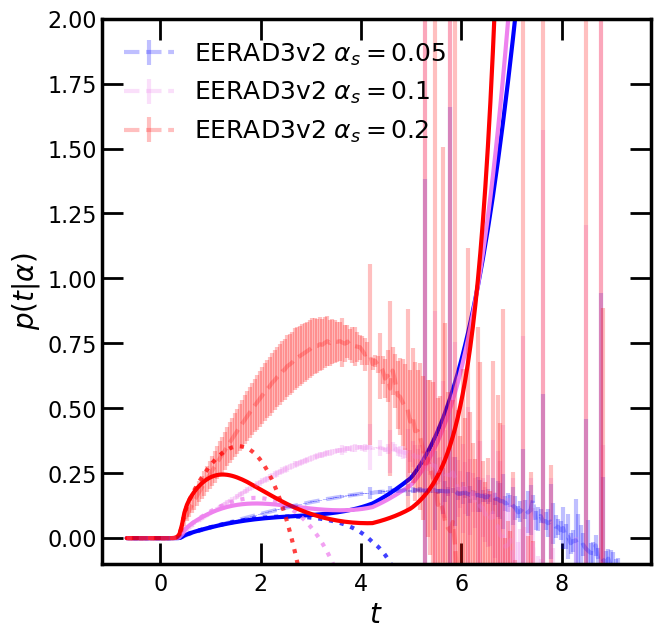

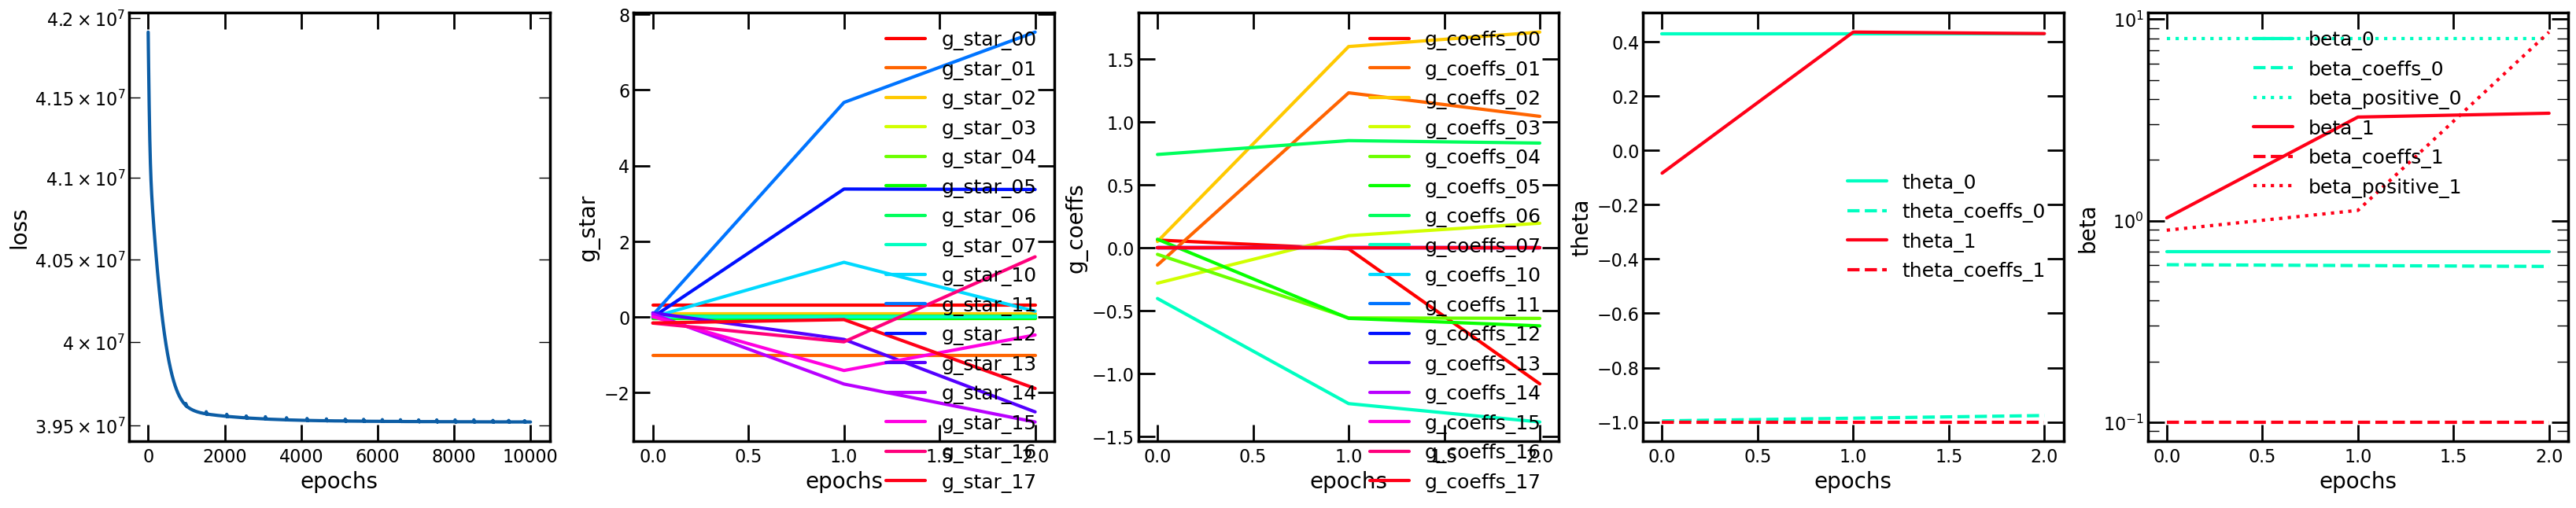

Epoch 15000 / 500000, Loss: 39517141.132294


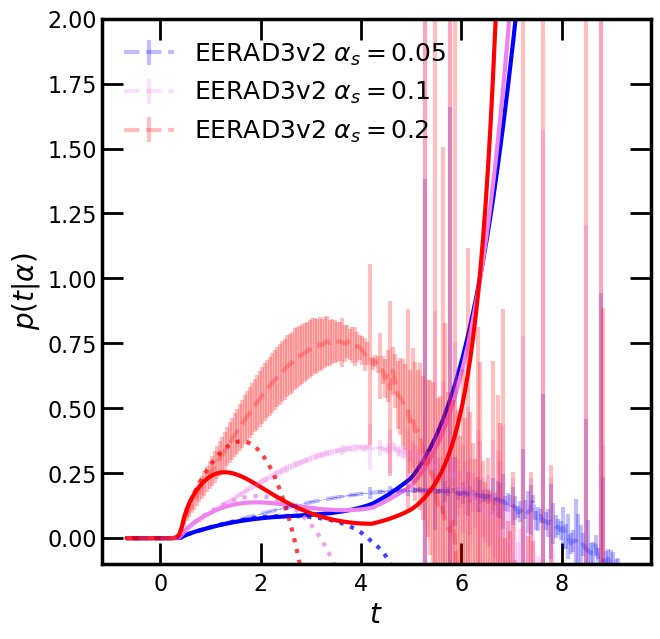

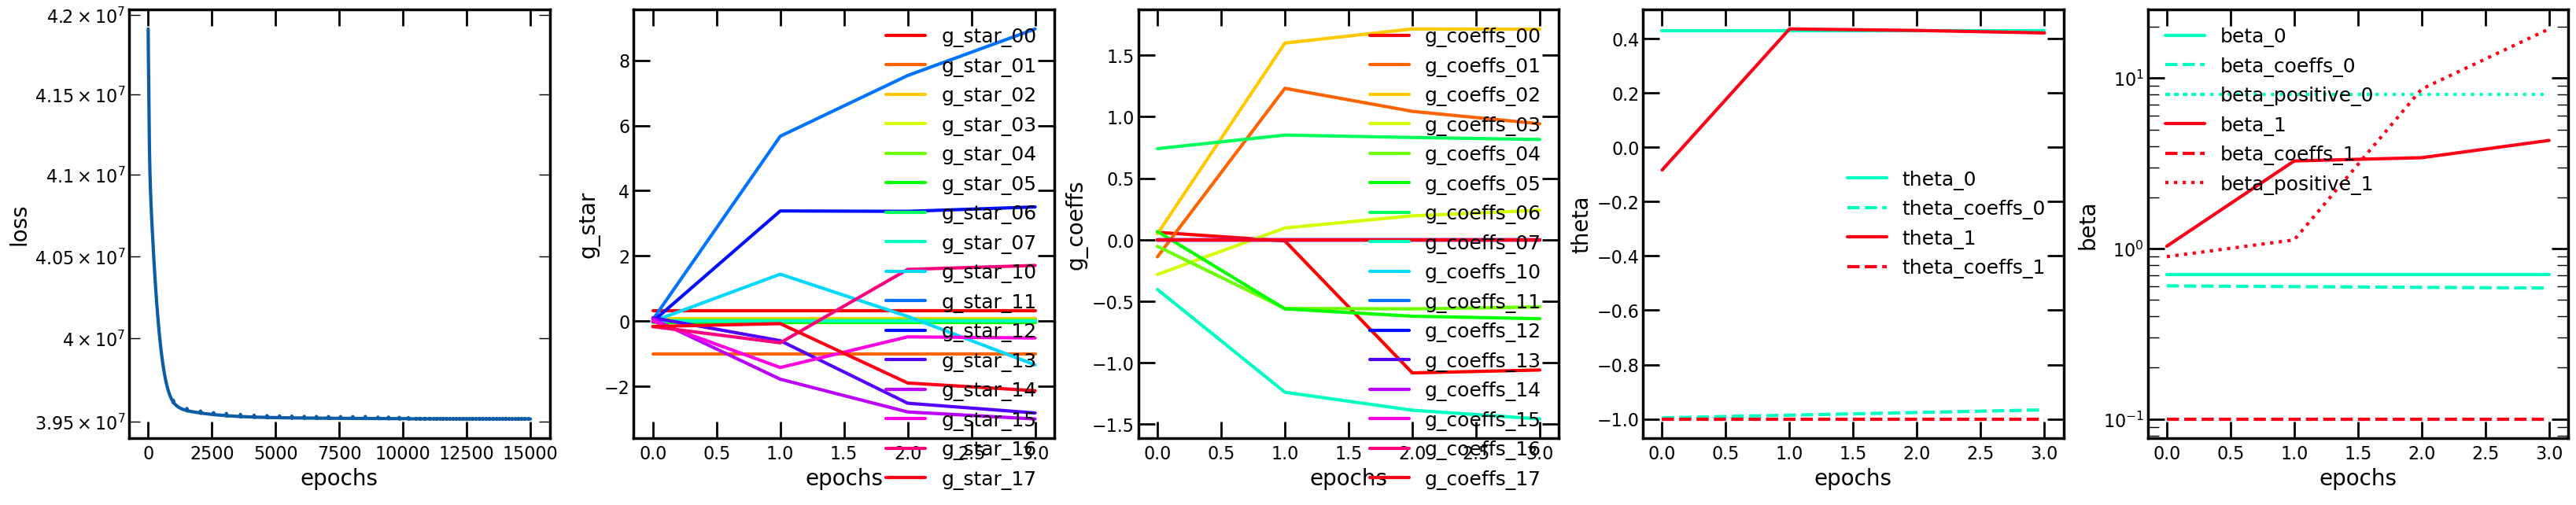

In [ ]:
loss, params, losses, params_log = train(0.118,
                                                 params,
                                                 epochs , 
                                                 lr, 
                                                 jax_key, 
                                                 verbose=True, 
                                                 verbose_epochs=verbose_epochs, 
                                                 bogo_init=True, 
                                                 early_stopping=250000*2, 
                                                 bogo_scale= bogo_scale, 
                                                 population=bogo_population,
                                                 bogo_epochs=bogo_epochs)



with open(f"output_JAX/{name}_params.pkl", "wb") as f:
    pickle.dump(params, f)

with open(f"output_JAX/{name}_params_history.pkl", "wb") as f:
    pickle.dump(params_log, f)

with open(f"output_JAX/{name}_loss_history.pkl", "wb") as f:
    pickle.dump(losses, f)

In [ ]:
print(params_log)

with open(f"output_JAX/{name}_params.pkl", "wb") as f:
    pickle.dump(params, f)

with open(f"output_JAX/{name}_params_history.pkl", "wb") as f:
    pickle.dump(params_log, f)

with open(f"output_JAX/{name}_loss_history.pkl", "wb") as f:
    pickle.dump(losses, f)

In [ ]:
"""
fig, ax = newplot("full", width = 8 * 5, subplot_array=(1, 5), use_tex = False)





losses = np.array(losses)
g_star_log = np.array([params_log[i]["g_star"] for i in range(len(params_log))])
g_coeffs_log = np.array([params_log[i]["g_coeffs"] for i in range(len(params_log))])
thetas_log = np.array([params_log[i]["thetas"] for i in range(len(params_log))])
temps_log = np.array([params_log[i]["temps"] for i in range(len(params_log))])
thetas_c_log_ = np.array([params_log[i]["thetas_coeffs"] for i in range(len(params_log))])
temps_c_log_ = np.array([params_log[i]["temps_coeffs"] for i in range(len(params_log))])


color = iter(
    cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[1] * g_coeffs_log.shape[2]))
)


ax[0].plot(losses)
ax[0].set_yscale("log")

for mi in range(g_star_log.shape[1]):

    for ni in range(g_star_log.shape[2]):

        c = next(color)

        ax[1].plot(g_star_log[:,mi,ni], color = c, label = f"g_star_{mi}{ni}")
        ax[2].plot(g_coeffs_log[:,mi,ni], color = c, label = f"g_coeffs_{mi}{ni}")

    ax[3].plot(thetas_log[:,mi], label = f"theta_{mi}", color = c)
    ax[4].plot(temps_log[:,mi], label = f"temp_{mi}", color = c)

    ax[3].plot(thetas_c_log_[:,mi], label = f"theta_coeffs_{mi}", color = c, ls = "--")
    ax[4].plot(temps_c_log_[:,mi], label = f"temp_coeffs_{mi}", color = c, ls = "--")

    

ax[0].set_ylabel("loss")
ax[0].set_xlabel("epochs")

ax[1].legend()
ax[1].set_ylabel("g_star")
ax[1].set_xlabel("epochs")

ax[2].legend()
ax[2].set_ylabel("g_coeffs")
ax[2].set_xlabel("epochs")

ax[3].legend()
ax[3].set_ylabel("theta")
ax[3].set_xlabel("epochs")


ax[4].legend()
ax[4].set_ylabel("temp")
ax[4].set_xlabel("epochs")
"""

In [ ]:
fig, ax = newplot("full", use_tex = False)


# params = {'g_coeffs': jnp.array([[-1.4129587e+00, -8.3932149e-01, -3.6408892e-01,  2.1668930e-01,
#          9.2633456e-02, -8.7050162e-02, -1.0447601e-01, -1.3033234e-02,
#          1.0823050e-01, -2.7595865e-02],
#        [ 1.9706091e-02,  1.0751380e-01,  7.2292695e-03,  7.2420542e-03,
#          3.4468577e-03, -6.2232531e-05,  1.3756469e-05,  5.0528266e-05,
#          3.6526422e-04, -5.9835085e-05]]), 'g_star': jnp.array([[ 3.6294520e-01, -1.0979660e+00,  1.9972968e-01, -8.7971516e-02,
#         -3.1348750e-02,  4.8306610e-02,  7.9979207e-03, -3.1092776e-02,
#          1.3078115e-02, -1.0615622e-04],
#        [-1.5308211e+00, -1.4279670e+00, -6.4494938e-01, -4.9874373e-02,
#          3.3021158e-01,  1.8047714e-01,  3.7153810e-02,  1.6338695e-02,
#          7.4233182e-02, -8.4546432e-02]]), 'thetas': jnp.array([0.44273797, 0.53100968])}

q_vals = Q_ANSATZ(t_bin_centers, keys, params)
q_taylor_vals = QM_ANSATZ(t_bin_centers, keys, params)

for (k, key) in enumerate(keys):
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]
    plt.errorbar(t_bin_centers, y, yerr, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
    #plt.plot(t_bin_centers, q_vals[k], color = colors[k])
    plt.plot(t_bin_centers, q_taylor_vals[k], color = colors[k], alpha = 0.75, ls = "dotted")

plt.xlim(0, 0.6)
plt.ylim(0.000001, 0.025)
# plt.xscale("log")
# plt.yscale("log")
plt.show()

print(params)


In [ ]:
# Make a plot of the data 
fig, ax = newplot("full", use_tex = False)
q_vals = Q_ANSATZ(t_bin_centers, keys, params)
q_taylor_vals = QM_ANSATZ(t_bin_centers, keys, params)

for (k, key) in enumerate(keys):
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]
    min_y_err = zero_error_scale * np.min(yerr[yerr > 0])
    plt.errorbar(t_bin_centers, y, yerr, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
    plt.plot(t_bin_centers, q_vals[k], color = colors[k])
    plt.plot(t_bin_centers, q_taylor_vals[k], color = colors[k], alpha = 0.75, ls = "dotted")

plt.ylim(-0.1, 2)
# plt.xscale("log")
plt.xlabel(r"$t$")
plt.ylabel(r"$p(t | \alpha)$")
plt.legend(loc = "upper left")






# x-version

# Make a plot of the data 
fig, ax = newplot("full", use_tex = False)
x_bin_centers = np.exp(-t_bin_centers) / mult_factor
q_vals = Q_ANSATZ(t_bin_centers, keys, params)
q_taylor_vals = QM_ANSATZ(t_bin_centers, keys, params)

for (k, key) in enumerate(keys):
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]

    min_y_err = zero_error_scale * np.min(yerr[yerr > 0])
    plt.errorbar(x_bin_centers, y/ x_bin_centers, yerr / x_bin_centers, color = colors[k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
    plt.plot(x_bin_centers, q_vals[k] / x_bin_centers, color = colors[k])
    plt.plot(x_bin_centers, q_taylor_vals[k] / x_bin_centers, color = colors[k], alpha = 0.75, ls = "dotted")

# plt.xlim(0, 0.5)
plt.yscale("log")
plt.ylim(1e-9, 1e6)
# plt.xscale("log")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$p(\tau | \alpha)$")
plt.legend(loc = "upper left")


In [ ]:
ls
